# Qué preguntas biologicas podemos abordar con pandas?
En la enciclopedia de genes y genomas de Kyoto ([KEGG](https://www.genome.jp/kegg/) por sus siglas en inglés), están depositadas cientos de rutas metabólicas y mapas celulares que se han construido mediante la integración de técnicas moleculares, genéticas, bioquímicas y de otras disciplinas.

## Unas rutas como ejemplo

A continuación enlistamos un par de rutas metabólicas que podrían ser de interés y que podemos analizar usando **Pandas**
* [hsa04930](https://www.genome.jp/pathway/hsa04930) - Type II diabetes mellitus
* [hsa05010](https://www.genome.jp/pathway/hsa05010) - Alzheimer disease
* [hsa05012](https://www.genome.jp/pathway/hsa05012) - Parkinson disease
* [hsa05030](https://www.genome.jp/pathway/hsa05030) - Cocaine addiction
* [hsa05144](https://www.genome.jp/pathway/hsa05144) - Malaria
* [hsa05210](https://www.genome.jp/pathway/hsa05210) - Colorectal cancer
* [hsa05224](https://www.genome.jp/pathway/hsa05224) - Breast cancer

Cada ruta consta de genes, proteínas, compuestos, reacciones, e interacciones entre cada elemento.

## Exploremos estas rutas con **Pandas**!

## 1. Cargamos los modulos necesarios

In [1]:
import os                                 # Con este módulo podemos manipular elementos del sistema operativo
import gzip                               # Este módulo lo emplearemos para manejar archivos comprimidos
import wget                               # wget & requests nos sirven para descargar archivos e interactuar con sitios web
import requests                           # 
import pandas as pd                       # nuestro módulo principal
import seaborn as sns                     # usaremos seaborn & matplotlib para graficar los resultados que obtengamos con pandas
import matplotlib.pyplot as plt           # 
from PIL import Image                     # finalmente, usaremos wordcloud y un par de módulos adicionales para analizar nuestras rutas
from wordcloud import WordCloud           #
from wordcloud import STOPWORDS           #
from wordcloud import ImageColorGenerator #

## 2. Descargamos el archivo gff que hemos empleado a lo largo del taller

<div class="alert alert-warning">Este paso es opcional ya que hemos trabajado con el mismo archivo desde el inicio, pero lo incluimos por si quieres realizar los ejercicios iniciando en este punto</div>

In [2]:
os.makedirs('data', exist_ok=True)
url      = 'http://ftp.ensembl.org/pub/release-104/gff3/homo_sapiens/Homo_sapiens.GRCh38.104.gff3.gz'
request  = requests.get(url, allow_redirects=True)
filename = "./data/Homo_sapiens.GRCh38.104.gff3.gz"
open(filename, "wb").write(request.content)

43154053

## 3. Construimos un dataframe con pandas indicando el nombre de las columnas con base en la especificación del formato gff

* Column 1: "seqid"
* Column 2: "source"
* Column 3: "type"
* Columns 4 & 5: "start" and "end"
* Column 6: "score"
* Column 7: "strand"
* Column 8: "phase"
* Column 9: "attributes"

In [3]:
df = pd.read_csv("data/Homo_sapiens.GRCh38.104.gff3.gz", sep="\t", comment="#", dtype="str", header=None, names=["seqid","source","type","start","end","score","strand","phase","attributes"])

## 4. Eliminamos las entradas en el archivo gff que correspondan a secuencias que no tienen aún una localizacion genómica

1. Primero haremos una copia del dataframe original, así, si cometemos un error podemos regresar al punto inicial *#bestpractices*
2. Posteriormente eliminamos las entradas que contengan `KI` o `GL` en la columna `seqid`
3. Reiniciamos el índice de nuestro nuevo dataframe

In [4]:
filtered_df = df.copy()
filtered_df = filtered_df[~filtered_df['seqid'].str.contains('[KI, GL]')].reset_index(drop=True)

## 5. Conservamos únicamente las entradas que correspondan al tipo `gene`

Recuerda que es recomendable construir una copia del dataframe original

In [5]:
genes = filtered_df.copy()
genes = genes[genes['type'] == 'gene'].reset_index(drop=True)

## 6. Construimos un nuevo dataframe pero únicamente con la novena columna del dataset (`attributes`)

1. Nuestro nuevo dataframe requiere los nombres de las columnas, las cuales están almacenadas en el diccionario `attribute_names`
2. Para no alterar el dataframe `genes` construimos una copia de dicho dataframe
3. Transformamos la columna 9 en un dataframe usando `";"` como separador

In [6]:
attribute_names = {0:"id",1:"name",2:"biotype",3:"description",4:"gene_id",5:"logic_name",6:"version"}
attributes = genes.copy()
attributes = attributes["attributes"].str.split(";",expand=True).rename(attribute_names,axis=1)

## 7. Construimos *otro* dataframe fusionando los dataframes `genes` & `attributes`

1. Dado que en el dataframe `attributes` ya tenemos la información de la columna 9, no necesitamos la columna `attributes` en el dataframe `genes`

In [7]:
genes_attributes = pd.concat([genes.drop("attributes",axis=1),attributes], axis=1)

## 8. Limpiamos el dataframe para quitarnos de strings no deseados

1. Usando una expresión regular, eliminamos todo aquello que esté antes de un signo `"="` en cada columna
2. Usando otra expresión regular, eliminamos el string `gene:` en cada columna
3. Usando una expresión regular más compleja, eliminamos todo aquello que inicie con `"[Source"` en cada columna

In [8]:
genes_attributes = genes_attributes.replace('.*=', '', regex=True).replace('gene:', '', regex=True).replace("\[Source.*","",regex=True)

## 9. Nuestro dataframe no está ordenado, de modo que debemos ordenarlo adecuadamente

### Cómo ordenamos los cromosomas?

* No podemos ordenar nuestros cromosomas de forma numérica porque tenemos 3 secuencias que no son números (`X`,`Y` & `MT` )
* No podemos ordenar nuestros cromosomas de forma numérica porque en el dataframe la columna `seqid` es de tipo `str`

#### Lo que si podemos hacer es ordenar nuestro dataframe usando una lista!

1. Construimos una nueva copia temporal del dataframe porque #sanitycheck
2. Construimos una copia adicional del dataframe, la cúal iremos alimentando con las entradas de cada cromosoma. Este dataframe contendrá inicialmente las entradas correspondientes únicamente al cromosoma 1
3. Construimos una lista con los cromosomas ordenados
4. Iteramos sobre nuestra lista, tomando los elementos del dataframe temporal que correspondan a cada cromosoma y los pasamos a nuestro dataframe final (paso 9.2)
5. Verificamos los resultados

In [9]:
genes_tmp = genes_attributes.copy()
genes_attributes_sorted = genes_tmp[genes_tmp["seqid"]=="1"]
chromosome_list = ["2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","X","Y","MT"]
for chromosome in chromosome_list:
    genes_chrom = genes_tmp[genes_tmp["seqid"]==chromosome]
    genes_attributes_sorted = pd.concat([genes_attributes_sorted,genes_chrom],axis=0)
display(pd.unique(genes_attributes["seqid"]))
display(pd.unique(genes_attributes_sorted["seqid"]))

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'MT',
       'X', 'Y'], dtype=object)

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X',
       'Y', 'MT'], dtype=object)

## 10. Cambiamos el tipo de datos en las columnas 4 y 5

1. En el paso 3, le indicamos a pandas que todas las columnas deben ser de tipo `str`, sin embargo, las columnas 4,5 & 6 deben ser de tipo numérico para que podamos sacarles el mayor provecho

In [10]:
genes_attributes_sorted["start"] = pd.to_numeric(genes_attributes_sorted["start"])
genes_attributes_sorted["end"]   = pd.to_numeric(genes_attributes_sorted["end"])

# Ejercicio X: Hay alguna relacion entre la posición genomica de los genes involucrados en rutas metabólicas?

### Empezaremos por escoger una lista de genes, recuerda que tienes las siguientes opciones:

* [hsa04930](https://www.genome.jp/pathway/hsa04930) - Type II diabetes mellitus
* [hsa05010](https://www.genome.jp/pathway/hsa05010) - Alzheimer disease
* [hsa05012](https://www.genome.jp/pathway/hsa05012) - Parkinson disease
* [hsa05030](https://www.genome.jp/pathway/hsa05030) - Cocaine addiction
* [hsa05144](https://www.genome.jp/pathway/hsa05144) - Malaria
* [hsa05210](https://www.genome.jp/pathway/hsa05210) - Colorectal cancer
* [hsa05224](https://www.genome.jp/pathway/hsa05224) - Breast cancer

Para seleccionar tu lista de genes, deja la línea correspondiente sin comentario

In [11]:
#pathway = "hsa04930.list"
#pathway = "hsa05010.list"
#pathway = "hsa05012.list"
#pathway = "hsa05030.list"
#pathway = "hsa05144.list"
#pathway = "hsa05210.list"
pathway = "hsa05224.list"
with open(pathway) as file:
    gene_list = file.readlines()
    gene_list = [gene.rstrip() for gene in gene_list]

### Ahora construimos un dataframe que contenga únicamente los genes que correspondan a nuestro pathway

In [12]:
pathway_df = genes_attributes_sorted.copy()
pathway_df = pathway_df[pathway_df["name"].isin(gene_list)]

### Y graficamos el resultado usando un `stripplot`
* Cada cromosoma representará una categoría en el eje Y (`y="seqid"`)
* Las coordenadas de inicio de cada gen serán nuestros puntos en el stripplot (`x="start"`)
* Separaremos nuestra gráfica por dirección del gen (`hue="strand"`)

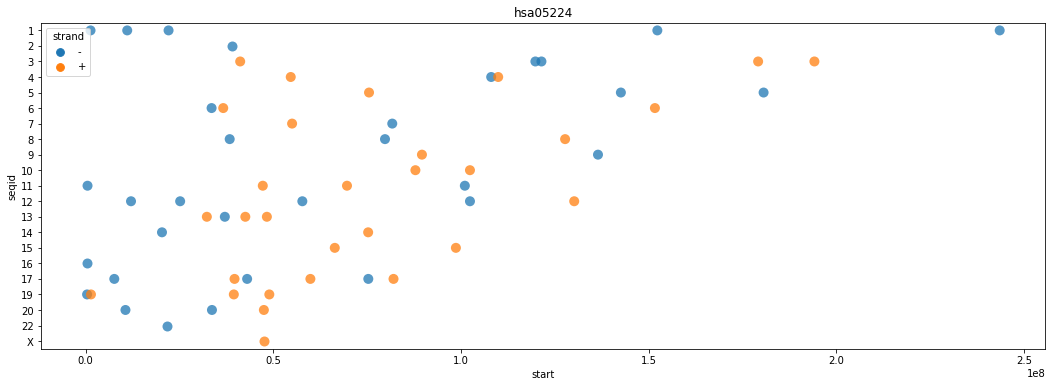

In [13]:
plt.figure(figsize=(18,6))
ax = sns.stripplot(data=pathway_df, x="start", y="seqid", hue="strand",size=10,alpha=0.75,jitter=0).set_title(pathway.split(".")[0])
plt.show()
plt.close()

## Para que hagas en casa

1. Selecciona distintas rutas metabólicas y grafica los resultados. Las distribuciones son similares?
2. En la ruta metabólica que seleccionaste, hay más genes en un cromosoma específico?
3. En la ruta metabólica que seleccionaste, hay más genes en las cadenas "+" o "-"?

# Ejercicio Y: La descripción de los genes nos puede decir algo de las rutas metabólicas?

Ya que tenemos nuestro dataframe filtrado y ordenado, podemos realizar conteos rápidos que nos brindan información de nuestras rutas metabólicas.

Una aproximacion ligera pero informativa son los wordclouds: representaciones gráficas en dónde las palabras se muestran con tamaños proporcionales a su frecuencia.

### Empezaremos por escoger una lista de genes, recuerda que tienes las siguientes opciones:

* [hsa04930](https://www.genome.jp/pathway/hsa04930) - Type II diabetes mellitus
* [hsa05010](https://www.genome.jp/pathway/hsa05010) - Alzheimer disease
* [hsa05012](https://www.genome.jp/pathway/hsa05012) - Parkinson disease
* [hsa05030](https://www.genome.jp/pathway/hsa05030) - Cocaine addiction
* [hsa05144](https://www.genome.jp/pathway/hsa05144) - Malaria
* [hsa05210](https://www.genome.jp/pathway/hsa05210) - Colorectal cancer
* [hsa05224](https://www.genome.jp/pathway/hsa05224) - Breast cancer

Para seleccionar tu lista de genes, deja la línea correspondiente sin comentario

In [14]:
#pathway = "hsa04930.list"
#pathway = "hsa05010.list"
#pathway = "hsa05012.list"
#pathway = "hsa05030.list"
#pathway = "hsa05144.list"
#pathway = "hsa05210.list"
pathway = "hsa05224.list"
with open(pathway) as file:
    gene_list = file.readlines()
    gene_list = [gene.rstrip() for gene in gene_list]
pathway_df = genes_attributes_sorted.copy()
pathway_df = pathway_df[pathway_df["name"].isin(gene_list)]

### Posteriormente tomamos las descripciones de los genes en nuestra ruta metabólica y las guardamos en una variable

In [15]:
gene_string = pathway_df["description"].to_list()
gene_string = str(gene_string).replace("\n","").replace(",","").replace("'","").strip()

### Y graficamos nuestro resultado

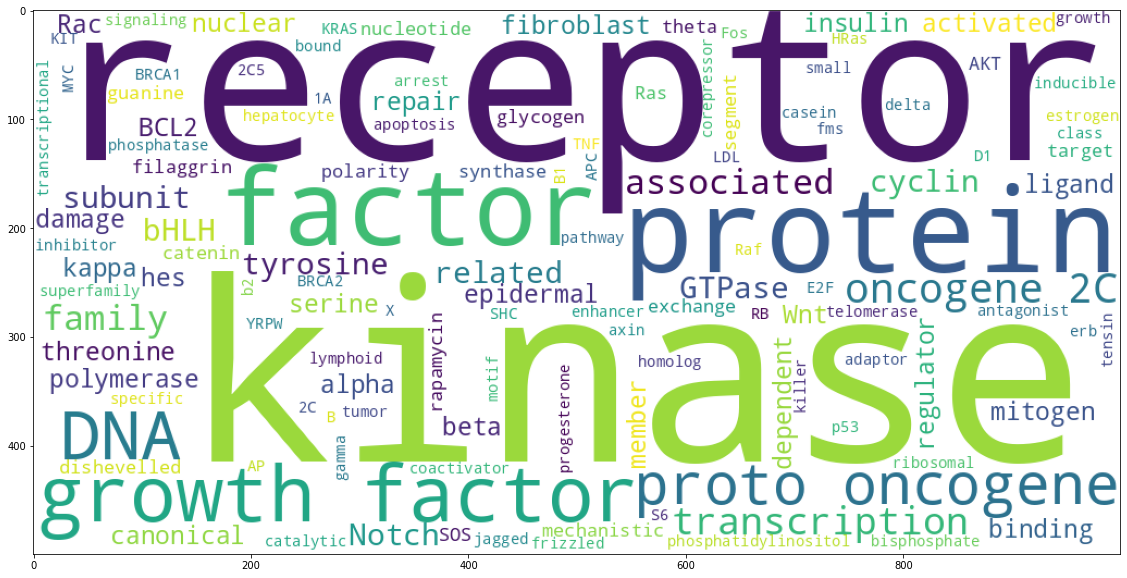

In [16]:
wordcloud = WordCloud(background_color="white",width=1000, height=500).generate(gene_string)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud);

## Para que hagas en casa

1. Selecciona distintas rutas metabólicas y grafica los resultados. Las distribuciones son similares?
2. Podrías ampliar tus listas de genes con base en lo que observaste en tus wordclouds?
3. Hay algunos términos que no son muy informativos, cómo podrías eliminarlos de tu wordcloud?

# Ejercicio Z: Digamos que me interesa analizar estos genes en el laboratorio. Cuanto me va a costar?

Actualmente se pueden realizar diversos estudios moleculares a nivel de genes, transcritos y proteínas, en este curso no hacemos distinción de ningun tipo y partiremos de un supuesto que es válido hasta el momento: "Cuanto más largo sea un gen o una molécula de RNA o una proteína, más me va a costar analizarlo". Y en consecuencia, cuantos más genes tenga mi pathway, más recursos debo invertir para analizarla.

### Empezaremos por escoger una lista de genes, recuerda que tienes las siguientes opciones:

* [hsa04930](https://www.genome.jp/pathway/hsa04930) - Type II diabetes mellitus
* [hsa05010](https://www.genome.jp/pathway/hsa05010) - Alzheimer disease
* [hsa05012](https://www.genome.jp/pathway/hsa05012) - Parkinson disease
* [hsa05030](https://www.genome.jp/pathway/hsa05030) - Cocaine addiction
* [hsa05144](https://www.genome.jp/pathway/hsa05144) - Malaria
* [hsa05210](https://www.genome.jp/pathway/hsa05210) - Colorectal cancer
* [hsa05224](https://www.genome.jp/pathway/hsa05224) - Breast cancer

Para seleccionar tu lista de genes, deja la línea correspondiente sin comentario

In [17]:
#pathway = "hsa04930.list"
#pathway = "hsa05010.list"
#pathway = "hsa05012.list"
#pathway = "hsa05030.list"
#pathway = "hsa05144.list"
#pathway = "hsa05210.list"
pathway = "hsa05224.list"
with open(pathway) as file:
    gene_list = file.readlines()
    gene_list = [gene.rstrip() for gene in gene_list]
pathway_df = genes_attributes_sorted.copy()
pathway_df = pathway_df[pathway_df["name"].isin(gene_list)]

### Ya que tenemos nuestro dataframe con genes únicamente de nuestro pathway, podemos obtener rapidamente la longitud de los genes que la conforman.

Pandas nos permite hacer cálculos y almacenar los resultados en columnas adicionales de nuestro dataframe.

Puedes identificar por qué agregamos un "1" al final?

In [18]:
pathway_df["length"] = (pathway_df["end"] - pathway_df["start"]) + 1
pathway_df.head()

,seqid,source,type,start,end,score,strand,phase,id,name,biotype,description,gene_id,logic_name,version,length
26,1,ensembl_havana,gene,1335276,1349418,.,-,.,ENSG00000107404,DVL1,protein_coding,dishevelled segment polarity protein 1,ENSG00000107404,ensembl_havana_gene_homo_sapiens,20,14143
140,1,ensembl_havana,gene,11106535,11262551,.,-,.,ENSG00000198793,MTOR,protein_coding,mechanistic target of rapamycin kinase,ENSG00000198793,ensembl_havana_gene_homo_sapiens,13,156017
290,1,ensembl_havana,gene,22117313,22143969,.,-,.,ENSG00000162552,WNT4,protein_coding,Wnt family member 4,ENSG00000162552,ensembl_havana_gene_homo_sapiens,15,26657
1230,1,ensembl_havana,gene,152302165,152325239,.,-,.,ENSG00000143631,FLG,protein_coding,filaggrin,ENSG00000143631,ensembl_havana_gene_homo_sapiens,11,23075
2011,1,ensembl_havana,gene,243488233,243851079,.,-,.,ENSG00000117020,AKT3,protein_coding,AKT serine/threonine kinase 3,ENSG00000117020,ensembl_havana_gene_homo_sapiens,19,362847


### Ahora calculamos la suma de las longitudes de los genes en nuestro dataframe

In [19]:
pathway_df["length"].sum()

4983379

### Cuantos genes tenemos en nuestro pathway?

In [20]:
len(pathway_df)

62

### Cuanto miden en promedio los genes en nuestro dataframe?

In [21]:
pathway_df["length"].sum()/len(pathway_df)

80377.08064516129

### Y ahora lo ponemos en perspectiva comparando los distintos pathways

In [22]:
pathway_list = ["hsa04930.list","hsa05010.list","hsa05012.list","hsa05030.list","hsa05144.list","hsa05210.list","hsa05224.list"]
pathway_array = []
for pathway in pathway_list:
    with open(pathway) as file:
        gene_list = file.readlines()
        gene_list = [gene.rstrip() for gene in gene_list]
    pathway_df = genes_attributes_sorted.copy()
    pathway_df = pathway_df[pathway_df["name"].isin(gene_list)]
    pathway_df["length"] = (pathway_df["end"] - pathway_df["start"]) + 1
    pathway_name    = pathway.split(".")[0]
    pathway_length  = pathway_df["length"].sum()
    pathway_count   = len(pathway_df)
    pathway_avg_length = pathway_length/pathway_count
    pathway_info = [pathway_name,pathway_count,pathway_length,pathway_avg_length]
    pathway_array.append(pathway_info)
    print(pathway_name + " tiene " + str(pathway_count) +  " genes con una longitud promedio de " + str(pathway_avg_length) + " bp, para un total de "  + str(pathway_length) + " bp")
pathway_array = pd.DataFrame(pathway_array, columns = ["pathway_name","pathway_count","pathway_length","pathway_avg_length"])
print("====="*10)
print("La ruta más cara de analizar por cuenta de genes es")
print(str(pathway_array.sort_values(by="pathway_count",ascending=False).head(1)["pathway_name"]))
print("====="*10)
print("La ruta más cara de analizar por longitud total es")
print(str(pathway_array.sort_values(by="pathway_length",ascending=False).head(1)["pathway_name"]))
print("====="*10)
print("La ruta menos cara de analizar por cuenta de genes es")
print(str(pathway_array.sort_values(by="pathway_count",ascending=True).head(1)["pathway_name"]))
print("====="*10)
print("La ruta menos cara de analizar por longitud total es")
print(str(pathway_array.sort_values(by="pathway_length",ascending=True).head(1)["pathway_name"]))
print("====="*10)

hsa04930 tiene 24 genes con una longitud promedio de 73420.79166666667 bp, para un total de 1762099 bp
hsa05010 tiene 121 genes con una longitud promedio de 87828.82644628099 bp, para un total de 10627288 bp
hsa05012 tiene 75 genes con una longitud promedio de 91180.89333333333 bp, para un total de 6838567 bp
hsa05030 tiene 27 genes con una longitud promedio de 69312.88888888889 bp, para un total de 1871448 bp
hsa05144 tiene 34 genes con una longitud promedio de 38314.85294117647 bp, para un total de 1302705 bp
hsa05210 tiene 59 genes con una longitud promedio de 96189.69491525424 bp, para un total de 5675192 bp
hsa05224 tiene 62 genes con una longitud promedio de 80377.08064516129 bp, para un total de 4983379 bp
La ruta más cara de analizar por cuenta de genes es
1    hsa05010
Name: pathway_name, dtype: object
La ruta más cara de analizar por longitud total es
1    hsa05010
Name: pathway_name, dtype: object
La ruta menos cara de analizar por cuenta de genes es
0    hsa04930
Name: path